In [1]:
import sys
import importlib
sys.path.append("/users/jmduchar/data/jmduchar/Research/mcgill25/rfi_characterization/python/")
import run_stan

import os
import numpy as np
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel
import json
import glob
import seaborn as sns
from tqdm import tqdm

plt.style.use('seaborn-v0_8')

In [2]:
ABS_DIR       = '/users/jmduchar/data/jmduchar/Research/mcgill25/rfi_characterization/'
LEGENDRE_FILE = ABS_DIR+'stan/legendre_bg_only.stan'
HMM_FILE      = ABS_DIR+'stan/hmm_on_residuals.stan'

DATA_SAVE_PATH = ABS_DIR+"/data/json/two_step_model"

DATAPATH = ABS_DIR+"data_private/raw_data/"
ANNOTATIONPATH = ABS_DIR+"data_private/annotations/"

ALL_FILES = glob.glob(DATAPATH+"*.npy")
ALL_ANNOTATIONS = glob.glob(ANNOTATIONPATH+"*.npy")

pointing = 'p0'
L = 8
sigma=0.33

In [ ]:
# Compile models
bg_model = CmdStanModel(stan_file=LEGENDRE_FILE)
hmm_model = CmdStanModel(stan_file=HMM_FILE)

16:56:27 - cmdstanpy - INFO - compiling stan file /oscar/data/jpober/jmduchar/Research/mcgill25/rfi_characterization/stan/hmm_on_residuals.stan to exe file /oscar/data/jpober/jmduchar/Research/mcgill25/rfi_characterization/stan/hmm_on_residuals


In [ ]:
importlib.reload(run_stan)

# Initial data dictionary
bg_data_dict = run_stan.create_data_dict_bg(
    pointing = pointing, 
    L = L, 
    sigma = sigma,
    save_data = True,
    data_save_path = "/users/jmduchar/data/jmduchar/Research/mcgill25/rfi_characterization/data/json/legendre_bg_only.json",
)

In [ ]:
w = bg_data_dict['w']
bg_data_dict['w'] = np.clip(w, 1e-6, 1.0)
max_loop = 6
eta = 0.5
tol = 1e-3  # convergence criterion

for i in tqdm(range(max_loop)):
    
    # 1) Legendre BG subtraction
    bg_fit = bg_model.sample(
        data            = bg_data_dict,
        chains          = 4,
        parallel_chains = 4,
        iter_sampling   = 10,
        iter_warmup     = 10,
        show_console    = False,
        output_dir      = ABS_DIR + 'stan/stan_out/'
    )
    
    mu = bg_fit.stan_variable("mu").mean(axis=0)  # avg background
    legendre_priors = run_stan.prior_params_from_fit(bg_fit)
    
    # 2) HMM on residuals
    z = np.asarray(bg_data_dict['y']) - mu
    
    hmm_data_dict = run_stan.create_data_dict_hmm(
        pointing, 
        z, 
        start_idx      = bg_data_dict['start_idx'], 
        stop_idx       = bg_data_dict['stop_idx'], 
        sigma          = float(bg_data_dict['sigma']), 
        save_data      = True, 
        data_save_path = "/users/jmduchar/data/jmduchar/Research/mcgill25/rfi_characterization/data/json/hmm_dict.json",
    )

    hmm_fit = hmm_model.sample(
        data            = hmm_data_dict,
        chains          = 4, 
        parallel_chains = 4,
        iter_sampling   = 10,
        iter_warmup     = 10,
        show_console    = False,
        output_dir      = ABS_DIR + 'stan/stan_out/'
    )
    
    # 3) Update clean weights
    w_new = hmm_fit.stan_variable("post_clean").mean(axis=0)
    
    # Damping + clipping (for numerical stability)
    w = (1.0 - eta) * w + eta * w_new
    w = np.clip(w, 1e-6, 1.0)
    
    bg_data_dict['w'] = w
    
    # Finally, update priors
    bg_data_dict.update(legendre_priors)

    # check convergence
    if i > 0:
        delta = np.mean(np.abs(w - w_prev)) / (np.mean(w_prev) + 1e-12)
        if delta < tol:
            print(fr"Converged at iter {i}: $\Delta w$={delta:.2e}")
            break

    w_prev = w.copy()

In [6]:
# Final draws
mu_draws = bg_fit.stan_variable("mu")
mu = mu_draws.mean(axis=0)

z = np.asarray(bg_data_dict['y']) - mu

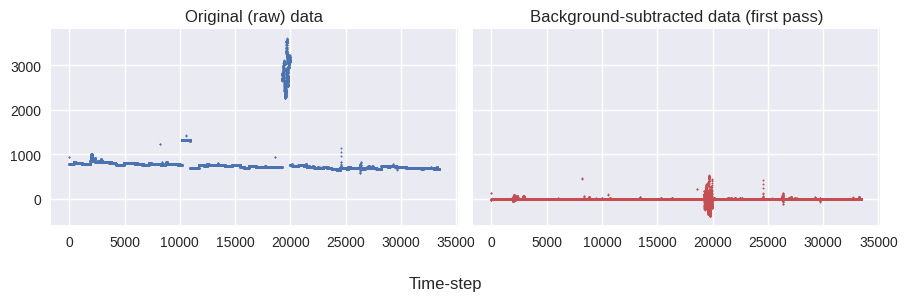

In [7]:
# Plot before and after
view_start = None
view_end = None

fig, axes = plt.subplots(1, 2, figsize=(9, 3), sharex=True, sharey=True)

axes[0].scatter(range(len(z))[view_start:view_end], np.asarray(bg_data_dict['y'])[view_start:view_end], s=1)
axes[0].set_title('Original (raw) data')

axes[1].scatter(range(len(z))[view_start:view_end], z[view_start:view_end], color=sns.color_palette()[2], s=1)
axes[1].set_title('Background-subtracted data (final pass)')

fig.supxlabel("Time-step")
plt.tight_layout()
plt.show()